# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [1]:
import os
import json
import scipy.stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

## 2. Verifying laws of software evolution

In [2]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '~/Documents/SE/eucalyptus'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [3]:
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort'
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
tags = list (line.strip().decode("utf-8") for line in process.stdout)
print(tags)

['1.0-beta', '1.4', '1.5.0', '1.5.1', '1.5.2', '1.6.1', '2.0.0', '2.0.1', '2.0-beta', '2.0-branch', '3.0.0', '3.0.1', '3.0-alpha1', '3.0-beta2', '3.0-beta3', '3.0-beta4', '3.0-beta5', '3.0-beta6', '3.0-rc1', '3.0-rc2', '3.0-rc3', '3.1.0', '3.1.1', '3.1.2', '3.1-alpha2', '3.1-beta1', '3.2.0', '3.2.1', '3.2.2', '3.3.0', '3.3.0.1', '3.3.1', '3.3.2', '3.3-m1', '3.3-m2', '3.3-m3', '3.3-m4', '3.3-m5', '3.3-m6', '3.4.0', '3.4.1', '3.4.2', 'ha-baseline', 'jaunty', 'karmic', 'v4.0.0', 'v4.0.1', 'v4.0.2', 'v4.1.0', 'v4.1.1', 'v4.1.2', 'v4.2.0', 'v4.2.1', 'v4.2.2', 'v4.3.0', 'v4.3.0.1', 'v4.3.1', 'v4.3.1.1', 'v4.4.0', 'v4.4.1', 'v4.4.2']


In [99]:
import re

versions = {}
major_minor_patch_versions = []

pattern = "^v?(\d\.\d)(\.\d)?$"

for tag in tags:
    m = re.search(pattern, tag)
    if m is not None:
        if not versions.get(m.groups()[0], False):
            versions[m.groups()[0]] = tag
        major_minor_patch_versions.append(tag)
               
major_minor_versions = list(versions.values())

print("Major_minor : ", major_minor_versions)
print("Major_minor_patch : ", major_minor_patch_versions)

Major_minor :  ['1.4', '1.5.0', '1.6.1', '2.0.0', '3.0.0', '3.1.0', '3.2.0', '3.3.0', '3.4.0', 'v4.0.0', 'v4.1.0', 'v4.2.0', 'v4.3.0', 'v4.4.0']
Major_minor_patch :  ['1.4', '1.5.0', '1.5.1', '1.5.2', '1.6.1', '2.0.0', '2.0.1', '3.0.0', '3.0.1', '3.1.0', '3.1.1', '3.1.2', '3.2.0', '3.2.1', '3.2.2', '3.3.0', '3.3.1', '3.3.2', '3.4.0', '3.4.1', '3.4.2', 'v4.0.0', 'v4.0.1', 'v4.0.2', 'v4.1.0', 'v4.1.1', 'v4.1.2', 'v4.2.0', 'v4.2.1', 'v4.2.2', 'v4.3.0', 'v4.3.1', 'v4.4.0', 'v4.4.1', 'v4.4.2']


In [100]:

major_minor_patch_versions1 = ['1.4','1.5.0','1.5.1','1.5.2','1.6.1','2.0.0','2.0.1','3.0.0','3.0.1','3.1.0','3.1.1','3.1.2','3.2.0','3.2.1',
                              '3.2.2','3.3.0','3.3.1','3.3.2','3.4.0','3.4.1','3.4.2','v4.0.0','v4.0.1','v4.0.2','v4.1.0','v4.1.1','v4.1.2',
                              'v4.2.0','v4.2.1','v4.2.2','v4.3.0','v4.3.1','v4.4.0','v4.4.1','v4.4.2']
major_minor_versions1 = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']

### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [103]:
command = ""
for version in major_minor_patch_versions:
    command += f'git -C {eucalyptus_project_path} reset --hard {version} && cloc {eucalyptus_project_path} --csv --quiet > data/{version}.csv && '

command = command[:-2]
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    
    

Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/groups/ServiceGroups.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/ClusterController.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/ComponentService.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/Database.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/Dns.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/Euare.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/main/java/com/eucalyptus/component/id/Eucalyptus.java
Unable to read /home/arnaubuntu/Documents/SE/eucalyptus/clc/modules/msgs/src/


1 error:
Line count, exceeded timeout:  /home/arnaubuntu/Documents/SE/eucalyptus/net/globalnetwork.c


In [9]:
#command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r' # to get the release date
#process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
# Your code to obtain the release date of each tag and combine it with the data obtained in the previous cell. Final data should have
# #lines of code, #comments, #files, #blanks, #release date

In [ ]:
# Your code here to get the versions of the form major.minor 

In [7]:
# Your code here to get the versions of the form major.minor.patch

#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

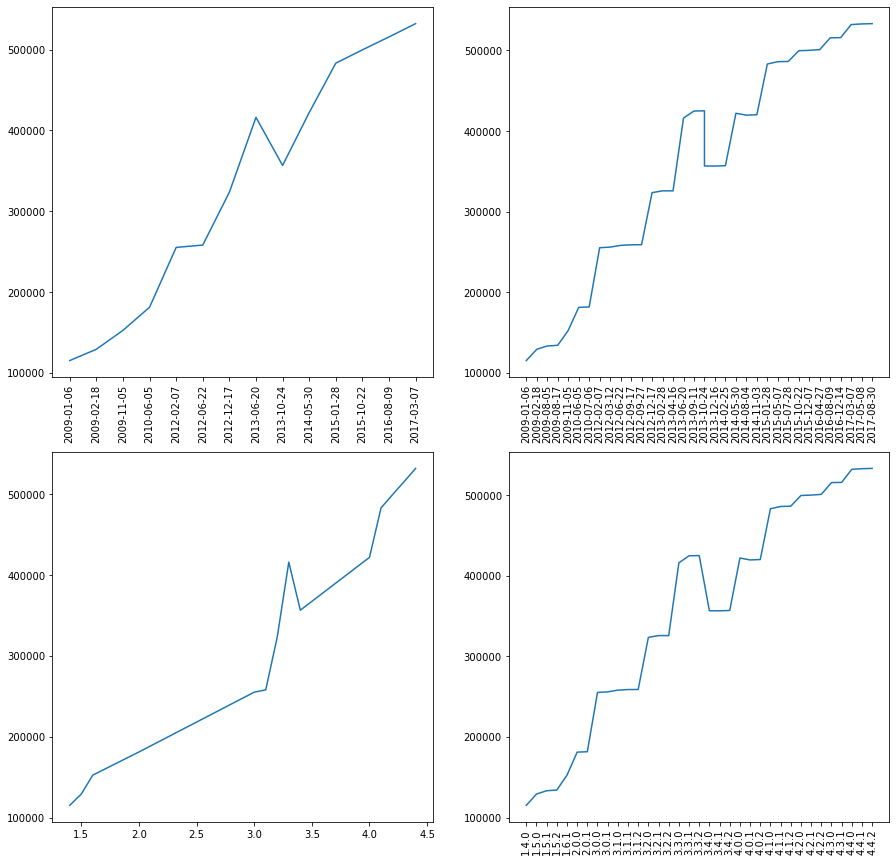

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

df1 = pd.read_csv("LIG_major_minor.csv", delimiter = ',')
df2 = pd.read_csv("LIG_major_minor_patch.csv", delimiter = ',')

#display(df2)

y1=df1["nb_code"]
x1=df1["date"]
x2=df1["major.minor"]
y3=df2["nb_code"]
x3=df2["date"]
x4=df2["major.minor.patch"]

axs[0, 0].plot(x1,y1)
axs[0, 0].tick_params('x', labelrotation=90)

axs[1, 0].plot(x2,y1)

axs[0, 1].plot(x3,y3)
axs[0, 1].tick_params('x', labelrotation=90)

axs[1, 1].plot(x4,y3)
axs[1, 1].tick_params('x', labelrotation=90)

plt.show()

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?



2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

tag in x-axis, date does not reflect wether huge update are made. One cannot justify the growth of the project with date but with tags it make more sens.

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

In [11]:
plt.figure(figsize=(7,7))
# Your code for regression plot

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [13]:
# Your code for correlation
pearson_corr = scipy.stats.pearsonr(df2["nb_code"], df2["nb_nfiles"])[0]

spearman_corr = scipy.stats.spearmanr(df2["nb_code"], df2["nb_nfiles"])[0]

print(f'Pearson correlation : {pearson_corr:.3f}')
print(f'Spearman correlation : {spearman_corr:.3f}')


Pearson correlation : 0.993
Spearman correlation : 0.977


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

Spearman and Peasron both show high correlation. 

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

In [14]:
df3 = df2.tail(2)


df2.drop(index=df2.index[-2:])

X = df2[["nb_blank","nb_comment","nb_nfiles"]]
y = df2["nb_code"]


model = LinearRegression()
model.fit(X, y)


X_predict = df3[["nb_blank","nb_comment","nb_nfiles"]]
y_predict = model.predict(X_predict)

print("data =\n", df3["nb_code"])

print("prediction=\n", y_predict)

data =
 33    532915
34    533292
Name: nb_code, dtype: int64
prediction=
 [521785.43260368 522053.91601528]


In [15]:
a = df2["nb_code"]
b = df2["nb_nfiles"]

result = scipy.stats.linregress(a, b)

In [ ]:
# Your code here

In [ ]:
# Your plotting code here

### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

1

7. What is the coefficient of determination? (R-squared)

8. What is the Root mean square error for the forecasted values?

### Filtering on coding language

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [95]:
df_current = pd.read_csv("data/data.csv", delimiter = ',')
df_14 = pd.read_csv("data/data2.csv", delimiter = ',')

[]

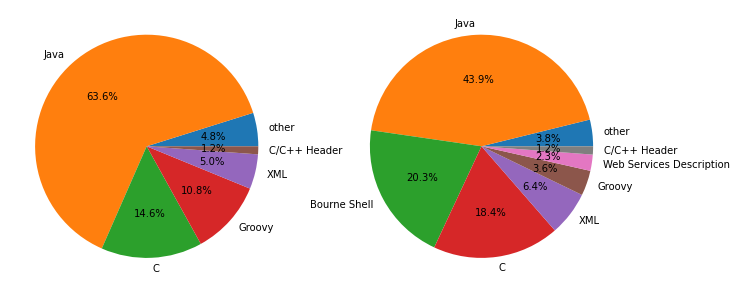

In [96]:
def compute_pie(df)  :  
    languages = df["language"]
    sizes = df["code"]

    total = sum(sizes)
    displayed_languages = {"other": 0}

    for language, size in zip(languages, sizes):
        if size < 0.01 * total:
            displayed_languages["other"] += int(size)
        else:
            displayed_languages[language] = int(size)
    return displayed_languages
        
dict1 = compute_pie(df_current)
dict2 = compute_pie(df_14)

fig, axs = plt.subplots(1, 2, figsize=(11, 11))
axs[0].pie(dict1.values(), labels=dict1.keys(), autopct='%1.1f%%')
axs[1].pie(dict2.values(), labels=dict2.keys(), autopct='%1.1f%%')
plt.plot() 

### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

Bourne shell is no more one of the main language in the project. Java proportion is greater in the lastest version

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

In [106]:
dfs=[]
for version in major_minor_patch_versions:
    dfs.append(pd.read_csv(f'data/{version}.csv', delimiter = ','))

for df in dfs:
    df.drop(df.tail(1).index,inplace=True)    
    


#df_301 = pd.read_csv("data3.csv", delimiter = ',')

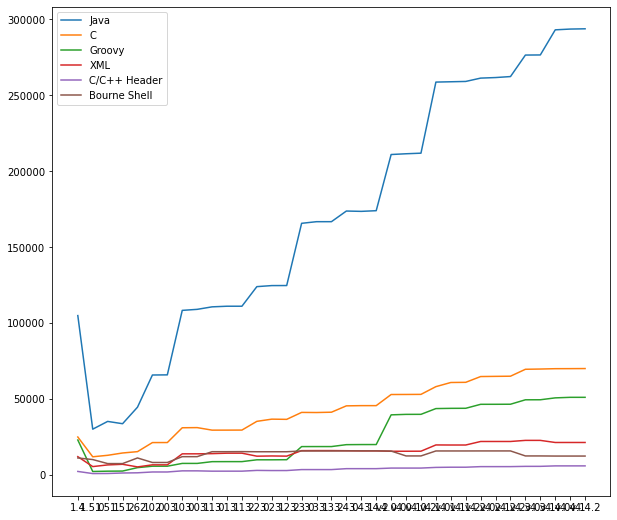

In [107]:
important_languages=["Java","C","Groovy","XML","C/C++ Header","Bourne Shell"]
fig, axs = plt.subplots(figsize=(10,9))
    

for lang in important_languages:
    l = [int(df[df['language']==lang]["code"]) for df in dfs]
    axs.plot(major_minor_patch_versions, l)

plt.legend(important_languages)    
plt.show()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

yes it does

11. Does this software project obey the Law of Increasing Growth?

yes it does

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

In [ ]:
# Your code and plot here

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [ ]:
eucalyptus_project_path = '' # your project path here
eucalyptus_copy_project_path = '' # your path to the copy of your project here
major_minor_patch_versions = '' #set of version that you would like to consider for this analysis

In [ ]:
# Your code here to get the data

In [ ]:
# Your code here to get the dates corresponding to the tags

In [ ]:
# Your plotting code here (all the features in a single plot)

In [ ]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2)

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

2. Does the law of increasing growth too hold good here?

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code) 

In [ ]:
# Your code here

In [ ]:
# Your plotting code here
fig,axes = plt.subplots(2,2)

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

4. Does this software project obey Law of Continuing Change?